In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-darkgrid")

In [38]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

# Análisis exploratorio de los datos

## Tabla Pedidos

In [39]:
pedidos = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "OrderList")

pedidos.columns = ["Pedido", "Fecha", "Puerto de origen", "Transportista", "TPT", "Nivel de servicio", "Envío adelantado [días]", 
                   "Envío tardío [días]", "Cliente", "Producto", "Planta", "Puerto de destino", "Items", "Peso [kg/item]"]

In [40]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Pedido                   9215 non-null   float64       
 1   Fecha                    9215 non-null   datetime64[ns]
 2   Puerto de origen         9215 non-null   object        
 3   Transportista            9215 non-null   object        
 4   TPT                      9215 non-null   int64         
 5   Nivel de servicio        9215 non-null   object        
 6   Envío adelantado [días]  9215 non-null   int64         
 7   Envío tardío [días]      9215 non-null   int64         
 8   Cliente                  9215 non-null   object        
 9   Producto                 9215 non-null   int64         
 10  Planta                   9215 non-null   object        
 11  Puerto de destino        9215 non-null   object        
 12  Items                    9215 non-

In [41]:
pedidos["Pedido"] = pedidos["Pedido"].astype(int)
lista = ["Puerto de origen", "Planta", "Puerto de destino"]
pedidos[lista] = pedidos[lista].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

*¿Cuál es el total de pedidos en esa fecha?*

In [42]:
pedidos.shape[0]

9215

*¿En qué fecha se realizaron los pedidos?*

In [43]:
d = pedidos["Fecha"].unique().astype("datetime64[D]").astype(str)
d[0]

'2013-05-26'

*¿Cuántos pedidos hubo por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [44]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Pedido": "size"})
pedidos_agrup = pedidos_agrup.rename(columns = {"Pedido": "Recuento"})

total = pedidos_agrup["Recuento"].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup["%"] = pedidos_agrup["Recuento"].apply(porcentaje)
pedidos_agrup.round(2)

,,,Recuento,%
Planta,Puerto de origen,Puerto de destino,,
3,4,9,8541,92.69
4,5,9,1,0.01
8,4,9,102,1.11
9,4,9,12,0.13
12,4,9,300,3.26
13,4,9,86,0.93
16,9,9,173,1.88


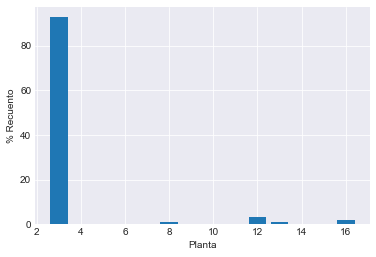

In [45]:
plt.figure(1)
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup["%"])
plt.xlabel("Planta")
plt.ylabel("% Recuento");

*¿Cuántos items hubo por cada conjunto Planta, Puerto de origen y Puerto de destino?*

In [46]:
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Items": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Items", "sum")].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup[("Items", "%")] = pedidos_agrup[("Items", "sum")].apply(porcentaje)
pedidos_agrup.round(2)

Items                              \
                                            min      mean     max       std   
Planta Puerto de origen Puerto de destino                                     
3      4                9                   235   3349.91  561847  16525.97   
4      5                9                   348    348.00     348       NaN   
8      4                9                   684   2715.76    5680   1504.06   
9      4                9                  2301  18652.50  101069  28877.08   
12     4                9                   236    373.33    1321    169.36   
13     4                9                   240    504.41    5244    609.10   
16     9                9                   280   1416.95    4464   1121.49   

                                                            
                                                sum      %  
Planta Puerto de origen Puerto de destino                   
3      4                9                  28611617  96.94  
4      5                9                       348   0.00  
8      4                9                    277008   0.94  
9      4                9                    223830   0.76  
12     4                9                    112000   0.38  
13     4                9                     43379   0.15  
16     9                9                    245133   0.83

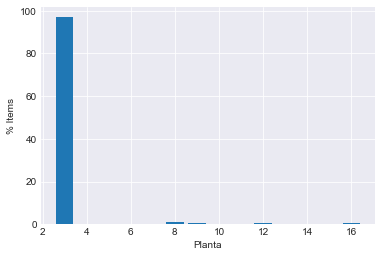

In [47]:
plt.figure(1)
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Items", "%")])
plt.xlabel("Planta")
plt.ylabel("% Items");

*Estadística descriptiva de Peso [kg/items] por cada conjunto Planta, Puerto de origen y Puerto de destino*

In [48]:
pedidos["Peso [kg]"] = pedidos["Items"] * pedidos["Peso [kg/item]"]
pedidos_agrup = pedidos.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Peso [kg]": ["min", "mean", "max", "std", "sum"]})

total = pedidos_agrup[("Peso [kg]", "sum")].sum()
porcentaje = lambda x: x / total * 100

pedidos_agrup[("Peso [kg]", "%")] = pedidos_agrup[("Peso [kg]", "sum")].apply(porcentaje)
pedidos_agrup.round(2)

Peso [kg]                            \
                                                min        mean           max   
Planta Puerto de origen Puerto de destino                                       
3      4                9                      0.00   450220.37  3.543400e+08   
4      5                9                    731.19      731.19  7.311900e+02   
8      4                9                   2080.80    54381.49  2.462982e+05   
9      4                9                  12300.18  1904321.00  1.737580e+07   
12     4                9                     87.48    17698.06  3.170878e+05   
13     4                9                     90.88   104671.33  4.963446e+06   
16     9                9                    219.77   417614.22  3.630482e+06   

                                                                            
                                                  std           sum      %  
Planta Puerto de origen Puerto de destino                                   
3      4                9                  6837051.65  3.845332e+09  97.10  
4      5                9                         NaN  7.311900e+02   0.00  
8      4                9                    55826.22  5.546912e+06   0.14  
9      4                9                  4966753.18  2.285185e+07   0.58  
12     4                9                    46996.80  5.309418e+06   0.13  
13     4                9                   543657.14  9.001734e+06   0.23  
16     9                9                   729269.77  7.224726e+07   1.82

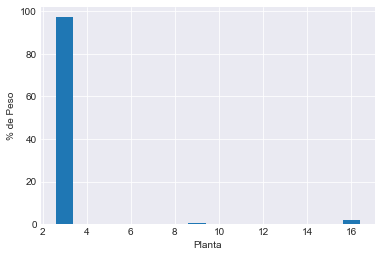

In [49]:
plt.figure(1)
plt.bar(x = pedidos_agrup.index.levels[0], height = pedidos_agrup[("Peso [kg]", "%")])
plt.xlabel("Planta")
plt.ylabel("% de Peso");

*¿Hay alguna correlación entre Peso [kg/items] e Items?*

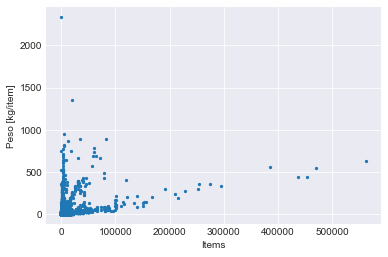

In [50]:
plt.figure(1)
plt.scatter(pedidos["Items"], pedidos["Peso [kg/item]"], s = 5)
plt.xlabel("Items")
plt.ylabel("Peso [kg/item]");

In [51]:
from scipy.stats import pearsonr 

r2, pvalue = pearsonr(x = pedidos["Items"], y = pedidos["Peso [kg/item]"])
round(r2, 3)

0.345

## Tabla Fletes

In [52]:
fletes = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "FreightRates")

fletes.columns = ["Transportista", "Puerto de origen", "Puerto de destino", "Peso mínimo [kg/item]", "Peso máximo [kg/item]", 
                  "Nivel de servicio", "Costo mínimo [USD/kg]", "Tasa de flete [USD/kg]", "Modo de transporte", "Envío [días]", 
                  "Tipo de transportista"]

In [53]:
fletes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transportista           1540 non-null   object 
 1   Puerto de origen        1540 non-null   object 
 2   Puerto de destino       1540 non-null   object 
 3   Peso mínimo [kg/item]   1540 non-null   float64
 4   Peso máximo [kg/item]   1540 non-null   float64
 5   Nivel de servicio       1540 non-null   object 
 6   Costo mínimo [USD/kg]   1540 non-null   float64
 7   Tasa de flete [USD/kg]  1540 non-null   float64
 8   Modo de transporte      1540 non-null   object 
 9   Envío [días]            1540 non-null   int64  
 10  Tipo de transportista   1540 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 132.5+ KB


In [54]:
lista = ["Puerto de origen", "Puerto de destino"]
fletes[lista] = fletes[lista].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)
fletes["Modo de transporte"] = fletes["Modo de transporte"].replace({"AIR   ": "Aire", "GROUND": "Tierra"}, regex = True)

*Estadística descriptiva de Tasa de flete [USD/kg] para cada conjunto Puerto de origen y Puerto de destino*

In [55]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Tasa de flete [USD/kg]": ["min", "mean", "max", "std"]})
fletes_agrup.round(2)

Tasa de flete [USD/kg]                     
                                                      min  mean     max    std
Puerto de origen Puerto de destino                                            
2                9                                   0.05  1.87    7.06   1.78
3                9                                   0.12  9.98  128.03  19.30
4                9                                   0.04  1.94    7.66   2.05
5                9                                   0.07  2.87   12.07   2.90
6                9                                   0.07  2.53    7.16   1.74
7                9                                   0.14  0.20    0.28   0.04
8                9                                   0.10  0.59    1.83   0.56
9                9                                   0.03  2.84   21.28   6.59
10               9                                   0.10  5.37   18.96   4.99
11               9                                   0.07  0.13    0.34   0.06

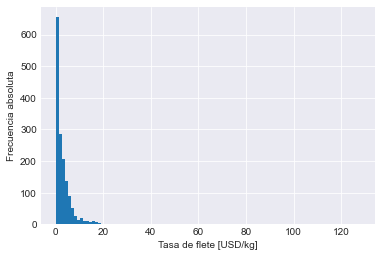

In [56]:
plt.figure(1)
plt.hist(fletes["Tasa de flete [USD/kg]"], bins = 100)
plt.xlabel("Tasa de flete [USD/kg]")
plt.ylabel("Frecuencia absoluta");

*Estadística descriptiva de Envío [días] para cada conjunto Puerto de origen y Puerto de destino*

In [57]:
fletes_agrup = fletes.groupby(by = ["Puerto de origen", "Puerto de destino"]).agg({"Envío [días]": ["min", "mean", "max", "size"]})
fletes_agrup.round(2)

Envío [días]               
                                            min  mean max size
Puerto de origen Puerto de destino                            
2                9                            0  1.62  14  226
3                9                            0  2.91  14   45
4                9                            0  1.58  14  231
5                9                            1  1.27   4  219
6                9                            1  1.99   3  479
7                9                            3  4.50   6   20
8                9                            2  4.82  14   39
9                9                            0  4.42  14   24
10               9                            2  3.17   6  222
11               9                            0  5.29  14   35

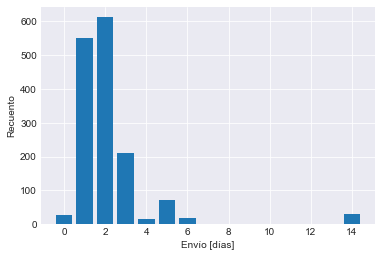

In [58]:
fletes_agrup = fletes.groupby(by = "Envío [días]").agg({"Envío [días]": "size"}).rename(columns = {"Envío [días]": "Recuento"})

plt.figure(1)
plt.bar(x = fletes_agrup.index, height = fletes_agrup["Recuento"])
plt.xlabel("Envío [días]")
plt.ylabel("Recuento");

*Estadística descriptiva de Modo de Transporte*

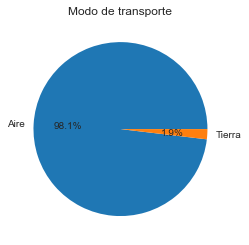

In [59]:
fletes_agrup = fletes.groupby(by = "Modo de transporte").agg({"Puerto de origen": "size"})
fletes_agrup = fletes_agrup.rename(columns = {"Puerto de origen": "Recuento de Puerto de origen"})

plt.figure(1)
plt.title("Modo de transporte")
plt.pie(x = fletes_agrup["Recuento de Puerto de origen"], labels = fletes_agrup.index, autopct = "%1.1f%%");

## Tabla Costos de Almacenaje

In [60]:
costos_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCosts")

costos_almacenaje.columns = ["Planta", "Costo específico [USD/item]"]

In [61]:
costos_almacenaje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Planta                       19 non-null     object 
 1   Costo específico [USD/item]  19 non-null     float64
dtypes: float64(1), object(1)
memory usage: 432.0+ bytes


In [62]:
costos_almacenaje["Planta"] = costos_almacenaje["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

*Estadística descriptiva de Costo específico [USD/item]*

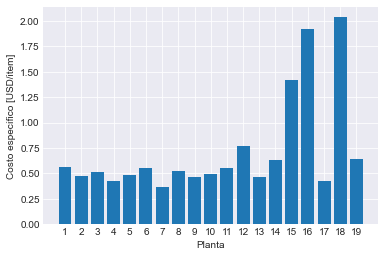

In [63]:
plt.figure(1)
plt.bar(x = costos_almacenaje["Planta"], height = costos_almacenaje["Costo específico [USD/item]"])
plt.xlabel("Planta")
plt.xticks(costos_almacenaje["Planta"])
plt.ylabel("Costo específico [USD/item]");

## Tabla Capacidad de Almacenaje

In [64]:
capacidad_almacenaje = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "WhCapacities")

capacidad_almacenaje.columns = ["Planta", "Capacidad [kg/día]"]

In [65]:
capacidad_almacenaje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Planta              19 non-null     object
 1   Capacidad [kg/día]  19 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 432.0+ bytes


In [66]:
capacidad_almacenaje["Planta"] = capacidad_almacenaje["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

*Estadística descriptiva de Capacidad [kg/día]*

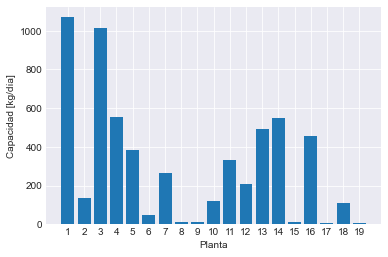

In [67]:
plt.figure(1)
plt.bar(x = capacidad_almacenaje["Planta"], height = capacidad_almacenaje["Capacidad [kg/día]"])
plt.xlabel("Planta")
plt.xticks(capacidad_almacenaje["Planta"])
plt.ylabel("Capacidad [kg/día]");

## Tabla Productos por cada Planta

In [68]:
productos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "ProductsPerPlant")

productos_por_planta.columns = ["Planta", "Producto"]

In [69]:
productos_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Planta    2036 non-null   object
 1   Producto  2036 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.9+ KB


In [70]:
productos_por_planta["Planta"] = productos_por_planta["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

*Estadística descriptiva de Recuento de Productos*

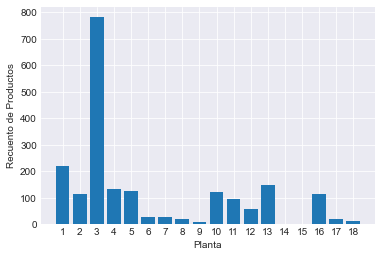

In [71]:
productos_agrup_por_planta = productos_por_planta.groupby(by = "Planta").agg({"Planta": "size"})
productos_agrup_por_planta = productos_agrup_por_planta.rename(columns = {"Planta": "Recuento de Productos"})

plt.figure(1)
plt.bar(x = productos_agrup_por_planta.index, height = productos_agrup_por_planta["Recuento de Productos"])
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Productos");

## Tabla Clientes por cada Planta

In [72]:
clientes_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "ProductsPerPlant")

clientes_por_planta.columns = ["Planta", "Cliente"]

In [73]:
clientes_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Planta   2036 non-null   object
 1   Cliente  2036 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.9+ KB


In [74]:
clientes_por_planta["Planta"] = clientes_por_planta["Planta"].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

*Estadística descriptiva de Clientes por cada Planta*

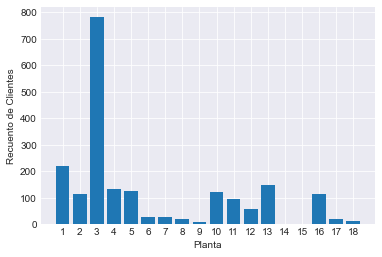

In [75]:
clientes_agrup_por_planta = clientes_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Clientes"})

plt.figure(1)
plt.bar(x = clientes_agrup_por_planta.index, height = clientes_agrup_por_planta["Recuento de Clientes"])
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Clientes");

## Tabla Puertos por cada Planta

In [76]:
puertos_por_planta = pd.read_excel("Logisitcs problem.xlsx", sheet_name = "PlantPorts").iloc[:, :2]

puertos_por_planta.columns = ["Planta", "Puerto de Origen"]

In [77]:
puertos_por_planta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Planta            22 non-null     object
 1   Puerto de Origen  22 non-null     object
dtypes: object(2)
memory usage: 480.0+ bytes


In [78]:
puertos_por_planta[["Planta", "Puerto de Origen"]] = puertos_por_planta[["Planta", "Puerto de Origen"]].replace(to_replace = "[^\d.]", value = "", regex = True).astype(int)

*Estadística descriptiva de Puertos por cada Planta*

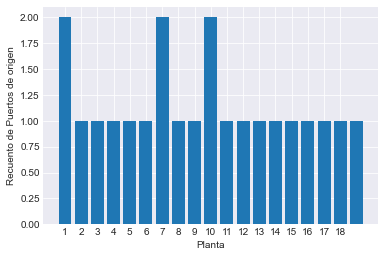

In [79]:
from scipy.stats import pearsonr, contingency, chisquare

puertos_agrup_por_planta = puertos_por_planta.groupby(by = "Planta").agg({"Planta": "size"}).rename(columns = {"Planta": "Recuento de Puertos de origen"})

plt.figure(1)
plt.bar(x = puertos_agrup_por_planta.index, height = puertos_agrup_por_planta["Recuento de Puertos de origen"])
plt.xlabel("Planta")
plt.xticks(productos_agrup_por_planta.index)
plt.ylabel("Recuento de Puertos de origen");

In [80]:
puertos_por_planta_pivot = puertos_por_planta.pivot_table(index = "Planta", columns = "Puerto de Origen", aggfunc = "size").fillna(0).astype(int)
puertos_por_planta_pivot.head()

Puerto de Origen,1,2,3,4,5,6,7,8,9,10,11
Planta,,,,,,,,,,,
1,1,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0


In [81]:
datos_esperados = contingency.expected_freq(puertos_por_planta_pivot)
resultados = chisquare(puertos_por_planta_pivot, datos_esperados, axis = None) #Estadístico Chi Cuadrado

resultados.statistic

198.0

## Tabla Completa

**Función Objetivo**\
Se desea conocer un conjunto de plantas de almacenaje, puertos de origen y puertos de destino que minimicen el costo total de la cadena de suministro. 
Matematicamente, se trata de un problema de optimización.

Costo total = Costo de almacenaje + Costo de transporte

El cliente decide qué nivel de servicio requiere:
- DTD: Puerta a Puerta (Door To Door)
- DTP: Puerta a Puerto (Door To Port)
- CRF: Carga Referida por el Cliente (Customer Referred Freight)

*Suposiciones:*

-
-
-
-


In [82]:
df1 = pd.merge(pedidos, fletes, on = ["Puerto de origen", "Puerto de destino", "Transportista", "Nivel de servicio"])
df2 = pd.merge(df1, costos_almacenaje, on = ["Planta"])
df3 = pd.merge(df2, capacidad_almacenaje, on = ["Planta"])

*Estadística Descriptiva del Costo de Almacenaje [USD]*

In [83]:
df3["Costo de almacenaje [USD]"] = df3["Items"] * df3["Costo específico [USD/item]"]
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo de almacenaje [USD]": ["min", "mean", "max", "sum"]})

total = df3_agrup[("Costo de almacenaje [USD]", "sum")].sum()
porcentaje = lambda x: x / total * 100

df3_agrup[("Costo de almacenaje [USD]", "%")] = df3_agrup[("Costo de almacenaje [USD]", "sum")].apply(porcentaje)
df3_agrup.round(2)

Costo de almacenaje [USD]           \
                                                                min     mean   
Planta Puerto de origen Puerto de destino                                      
3      4                9                                    121.61  1170.68   
8      4                9                                    357.63  1430.16   
9      4                9                                   1070.13  8674.74   
12     4                9                                    182.46   291.55   
13     4                9                                    112.73   236.92   
16     9                9                                    539.47   703.10   

                                                                           
                                                 max           sum      %  
Planta Puerto de origen Puerto de destino                                  
3      4                9                  290756.89  1.613191e+08  97.24  
8      4                9                    2969.83  1.444466e+06   0.87  
9      4                9                   47004.27  1.040969e+06   0.63  
12     4                9                    1021.31  1.862992e+06   1.12  
13     4                9                    2463.14  2.037542e+05   0.12  
16     9                9                    1581.92  2.390544e+04   0.01

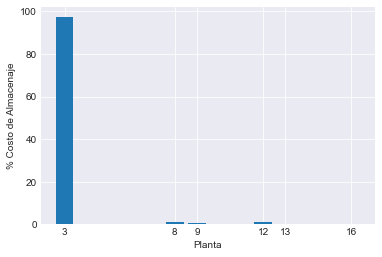

In [84]:
plt.figure(1)
plt.bar(x = df3_agrup.index.levels[0], height = df3_agrup[("Costo de almacenaje [USD]", "%")])
plt.xlabel("Planta")
plt.xticks(df3_agrup.index.levels[0])
plt.ylabel("% Costo de Almacenaje");

*Estadística Descriptiva del Costo de Transporte [USD]*

In [85]:
df3["Costo de transporte [USD]"] = np.where(df3["Nivel de servicio"] == "CRF", 0, df3["Items"] * df3["Peso [kg/item]"] * df3["Tasa de flete [USD/kg]"])
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo de transporte [USD]": ["min", "mean", "max", "sum"]})

total = df3_agrup[("Costo de transporte [USD]", "sum")].sum()
porcentaje = lambda x: x / total * 100

df3_agrup[("Costo de transporte [USD]", "%")] = df3_agrup[("Costo de transporte [USD]", "sum")].apply(porcentaje)
df3_agrup.round(2)

Costo de transporte [USD]  \
                                                                min   
Planta Puerto de origen Puerto de destino                             
3      4                9                                      0.00   
8      4                9                                     88.23   
9      4                9                                    521.53   
12     4                9                                      3.71   
13     4                9                                      3.85   
16     9                9                                   2698.44   

                                                                   \
                                                mean          max   
Planta Puerto de origen Puerto de destino                           
3      4                9                   16635.35  17150058.30   
8      4                9                    2392.90     11920.83   
9      4                9                   83028.40    840988.85   
12     4                9                    2735.21     98032.14   
13     4                9                    4563.67    240230.79   
16     9                9                  583942.84   9561053.88   

                                                                
                                                    sum      %  
Planta Puerto de origen Puerto de destino                       
3      4                9                  2.292351e+09  97.71  
8      4                9                  2.416832e+06   0.10  
9      4                9                  9.963407e+06   0.42  
12     4                9                  1.747802e+07   0.75  
13     4                9                  3.924756e+06   0.17  
16     9                9                  1.985406e+07   0.85

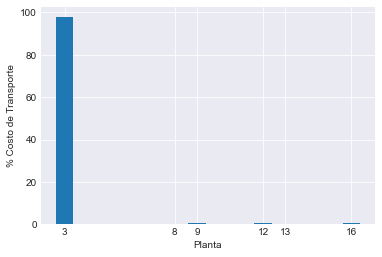

In [86]:
plt.figure(1)
plt.bar(x = df3_agrup.index.levels[0], height = df3_agrup[("Costo de transporte [USD]", "%")])
plt.xlabel("Planta")
plt.xticks(df3_agrup.index.levels[0])
plt.ylabel("% Costo de Transporte");

*Estadística Descriptiva del Costo Total [USD]*

In [87]:
df3["Costo total [USD]"] = df3["Costo de almacenaje [USD]"] + df3["Costo de transporte [USD]"]
df3_agrup = df3.groupby(by = ["Planta", "Puerto de origen", "Puerto de destino"]).agg({"Costo total [USD]": ["min", "mean", "max", "sum"]})

total = df3_agrup[("Costo total [USD]", "sum")].sum()
porcentaje = lambda x: x / total * 100

df3_agrup[("Costo total [USD]", "%")] = df3_agrup[("Costo total [USD]", "sum")].apply(porcentaje)
df3_agrup.round(2)

Costo total [USD]             \
                                                        min       mean   
Planta Puerto de origen Puerto de destino                                
3      4                9                            121.72   17806.02   
8      4                9                            445.86    3823.07   
9      4                9                           1591.66   91703.13   
12     4                9                            192.14    3026.76   
13     4                9                            121.62    4800.59   
16     9                9                           3385.73  584645.94   

                                                                             
                                                   max           sum      %  
Planta Puerto de origen Puerto de destino                                    
3      4                9                  17440815.18  2.453670e+09  97.68  
8      4                9                     14871.84  3.861298e+06   0.15  
9      4                9                    887993.12  1.100438e+07   0.44  
12     4                9                     98823.05  1.934101e+07   0.77  
13     4                9                    242693.93  4.128510e+06   0.16  
16     9                9                   9561693.17  1.987796e+07   0.79

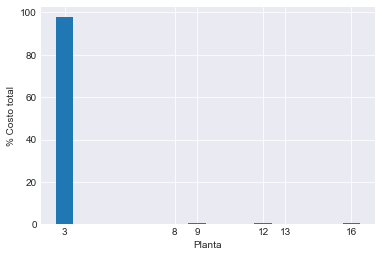

In [88]:
plt.figure(1)
plt.bar(x = df3_agrup.index.levels[0], height = df3_agrup[("Costo total [USD]", "%")])
plt.xlabel("Planta")
plt.xticks(df3_agrup.index.levels[0])
plt.ylabel("% Costo total");

In [89]:
#idx = pd.IndexSlice
#df3_agrup.loc[idx[:, 4, 9], :]